# A/B-тест двух версий рекламного объявления на сайте

**Задача:** по собранным данным сделать вывод о том, какая версия рекламы приносит больше выручки и конверсии в покупку.

**Вывод:** не рекомендуется выкатывать новую версию рекламы, лучше оставить имеющуюся.

### Импортируем библиотеки и датасет.

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest
import warnings

warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('AB_Test_Results.csv')

### Изучаем, все ли в порядке со значениями.

In [11]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


**USER_ID** -- айди пользователя

**VARIANT_NAME** -- контрольная/тестовая группа

**REVENUE** -- выручка с пользователя

In [12]:
df.tail()

,USER_ID,VARIANT_NAME,REVENUE
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0
9999,9468,control,0.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [13]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Сразу бросается в глаза, что количество записей больше количества пользователей.

In [26]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [25]:
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

Также мы замечаем, что некторые пользователи видели обе версии рекламы.

In [35]:
single_group = df.groupby('USER_ID')['VARIANT_NAME'].nunique()[df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1]
single_group

USER_ID
2       1
4       1
5       1
6       1
9       1
       ..
9990    1
9992    1
9993    1
9995    1
9998    1
Name: VARIANT_NAME, Length: 4783, dtype: int64

In [47]:
df = df[df['USER_ID'].isin(single_group.index)]
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0


Теперь у нас остались только юзеры, которые видели 1 вариант рекламы.

Можем посмотреть на группы:


In [57]:
df.groupby('VARIANT_NAME').agg({'USER_ID': ['count', 'nunique'], 'REVENUE': ['sum', 'mean', 'median']})

USER_ID         REVENUE                 
               count nunique     sum      mean median
VARIANT_NAME                                         
control         3026    2390  470.56  0.155506    0.0
variant         3044    2393  179.32  0.058909    0.0

Еще одна метрика, которую хотелось бы посмотреть - как изменилось число покупок и платящих пользователей.

In [60]:
df[df['REVENUE'] > 0].groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,54.0,8.714074,26.627446,0.02,1.585,3.12,6.0075,196.01
variant,43.0,4.170233,4.932851,0.02,1.250,2.72,4.2700,23.04


Средние очень сильно отличаются, а медианы нет.

Также судя по стандартному отклонению и максимальному значению, мы имеем выбросы в контрольной группе. Посмотрим на них:

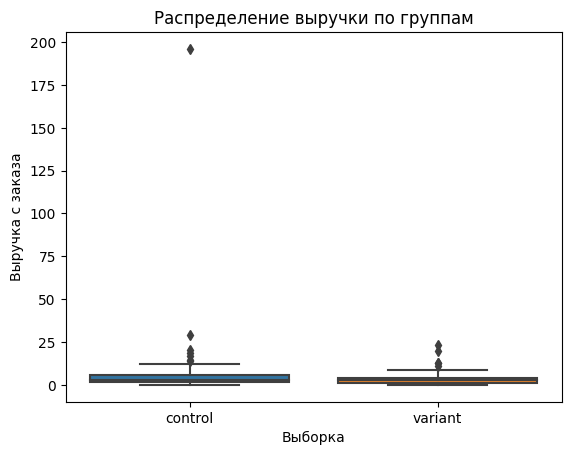

In [77]:
sns.boxplot(data=df[df['REVENUE'] > 0], x='VARIANT_NAME', y='REVENUE')
plt.ylabel('Выручка с заказа')
plt.xlabel('Выборка')
plt.title('Распределение выручки по группам');

Действительно, в контрольной группе есть довольно большой выброс. Уберем его.

In [83]:
no_ejections = df[df['REVENUE'] < 50]

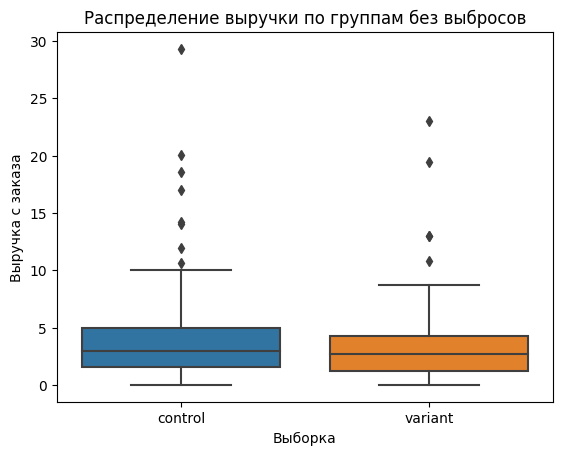

In [85]:
sns.boxplot(data=no_ejections[no_ejections['REVENUE'] > 0], x='VARIANT_NAME', y='REVENUE')
plt.ylabel('Выручка с заказа')
plt.xlabel('Выборка')
plt.title('Распределение выручки по группам без выбросов');

Посмотрим не совершал ли выброшенный пользователь еще каких-нибудь покупок:

In [186]:
ejection = df[df['REVENUE'] > 50]
ejection

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


In [185]:
df[df['USER_ID'] == ejection['USER_ID'].values[0]]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


Пользователь 3342 сделал всего одну большую покупку, поэтому можем убрать его из наблюдений, чтобы среднее сильно не смещалось.

Вернемся к полученным выборкам. Они уже стали уже больше похожи друг на друга. Посмотрим еще раз сводку по ним:

In [86]:
no_ejections.groupby('VARIANT_NAME').agg({'USER_ID': ['count', 'nunique'], 'REVENUE': ['sum', 'mean', 'median']})

USER_ID         REVENUE                 
               count nunique     sum      mean median
VARIANT_NAME                                         
control         3025    2389  274.55  0.090760    0.0
variant         3044    2393  179.32  0.058909    0.0

In [87]:
no_ejections[no_ejections['REVENUE'] > 0].groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,53.0,5.180189,5.942771,0.02,1.56,2.99,4.98,29.32
variant,43.0,4.170233,4.932851,0.02,1.25,2.72,4.27,23.04


In [116]:
arppu_control = round(274.55 / 53, 2)
arppu_variant = round(179.32 / 43, 2)
print(f'ARPPU control: {arppu_control}, ARPPU variant: {arppu_variant}')

ARPPU control: 5.18, ARPPU variant: 4.17


Теперь выборки уже похожи друг на друга. Но все равно контрольная кажется выигрышной по ряду метрик: **количество покупок**, **средний чек** и **ARPPU**.



Теперь вернемся к количеству платящих пользователей.

In [119]:
no_ejections[no_ejections['REVENUE'] > 0].groupby('VARIANT_NAME')['USER_ID'].nunique()

VARIANT_NAME
control    53
variant    42
Name: USER_ID, dtype: int64

Выглядит нормально. Почти все платящие пользователи совершили по 1 покупке. Не будем учитывать эту метрику, потому что она практически идентична среднему чеку в нашем случае.

Приступим к тестам.

К сожалению, неизвестно какой ожидался эффект от измененной рекламы (MDE), поэтому трудно оценить заложенные уровень значимости (alpha) и мощность теста (1 - beta).

### Проверяем гипотезы

Гипотезы (H0) следующие:

1) Конверсия в покупку не изменилась
2) Средний чек (в нашем случае он почти эквивалентен ARPPU) не изменился

### H0: Конверсия в покупку не изменилась
### H1: Конверсия в покупку изменилась

Я считаю, что нужно смотреть на отношение кол-ва покупок к количеству просмотров рекламы, а не к кол-ву уникальных просмотров, потому что многократный просмотр одной и той же рекламы может повлиять на решение пользователя купить товар.

In [144]:
# количество просмотров рекламы в контрольной группе
views_control = no_ejections[no_ejections['VARIANT_NAME'] == 'control']['USER_ID'].count()

# количество просмотров рекламы в тестовой группе
views_variant = no_ejections[no_ejections['VARIANT_NAME'] == 'variant']['USER_ID'].count()

# количество покупок в контрольной группе
buys_control = no_ejections[(no_ejections['VARIANT_NAME'] == 'control') & \
                           (no_ejections['REVENUE'] > 0)]['USER_ID'].count()

# количество покупок в тестовой группе
buys_variant = no_ejections[(no_ejections['VARIANT_NAME'] == 'variant') & \
                           (no_ejections['REVENUE'] > 0)]['USER_ID'].count()

In [146]:
_, pval =  proportions_ztest([buys_control, buys_variant], [views_control, views_variant])
pval, pval < 0.05

(0.2892743961405324, False)

Мы не отклоняем H0, потому что получили p-value гораздо большее, чем 0.05 (я решил взять классический уровень знаимости alpha).

Получается, что статистически значимых различий в конверсии в покупку мы не обнаружили.

### H0: Средний чек не изменился
### H1: Средний чек изменился

In [162]:
# средний чек в контрольной группе
aov_control = no_ejections[(no_ejections['VARIANT_NAME'] == 'control') & \
                          (no_ejections['REVENUE'] > 0)]['REVENUE']

# средний чек в тестовой группе
aov_variant = no_ejections[(no_ejections['VARIANT_NAME'] == 'variant') & \
                          (no_ejections['REVENUE'] > 0)]['REVENUE']

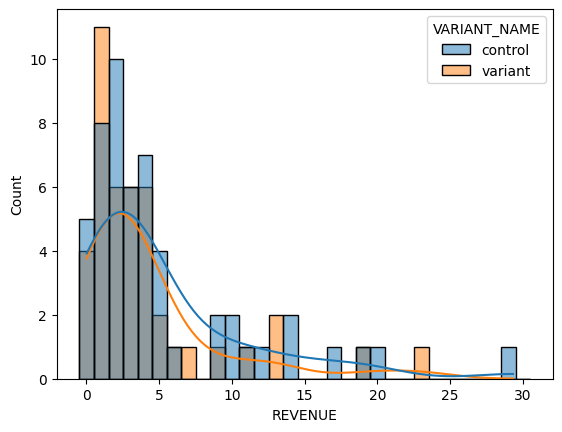

In [205]:
no_ejection_dist = no_ejections[no_ejections['REVENUE'] > 0]

sns.histplot(no_ejection_dist, x='REVENUE', hue='VARIANT_NAME', discrete=True, kde=True);

Видно, что люди из контрольной группы в большинстве своем покупают чуть более дорогие товары, а в тестовой наоборот - больше самых дешевых.

И хоть "на глаз" хорошо видно, что данные не распределены нормально, для формальности проведем **тест Шапиро-Уилка** на нормальность распределения (H0 - распределение не отличается от нормального, H1 - отличается).

In [212]:
_, pval = stats.shapiro(no_ejections['REVENUE'])
pval, pval < 0.05

(0.0, True)

Да, мы убедились, что распределение отлично от нормального.

Значит далее будем использовать непараметрический **U-критерий Манна-Уитни**.

In [213]:
# средний чек в контрольной группе
aov_control = no_ejections[no_ejections['VARIANT_NAME'] == 'control']['REVENUE']

# средний чек в тестовой группе
aov_variant = no_ejections[no_ejections['VARIANT_NAME'] == 'variant']['REVENUE']

In [215]:
_, pval = stats.mannwhitneyu(aov_control, aov_variant)
pval, pval < 0.05

(0.2859842308619548, False)

H0 не отклонена, статистически значимых изменений не обнаружено.

Нюанс в том, что почти все данные - нули. С таким большим количество наблюдений нужно быть очень внимательным и осторожным при проведении U-теста.

На всякий случай мы проверим, не изменится ли результат, если мы уберем все REVENUE = 0.

In [226]:
# средний чек в контрольной группе
aov_control_not_null = no_ejections[(no_ejections['VARIANT_NAME'] == 'control') & \
                            (no_ejections['REVENUE'] > 0)]['REVENUE']

# средний чек в тестовой группе
aov_variant_not_null = no_ejections[(no_ejections['VARIANT_NAME'] == 'variant') & \
                            (no_ejections['REVENUE'] > 0)]['REVENUE']

In [229]:
_, pval = stats.mannwhitneyu(aov_control_not_null, aov_variant_not_null)
pval, pval < 0.05

(0.4218148352342157, False)

Нет, все равно значимых изменений нет. U-критерий даже сильно вырос, когда мы убрали огромное количество нулей.

 ### Альтернативные проверки

Хоть это не совсем корректно, но интереса ради проведем пару параметрических тестов для этих данных (t-тест и z-тест).

In [225]:
_, pval = stats.ttest_ind(aov_control, aov_variant)
pval

0.17149090193658395

In [224]:
_, pval = ztest(aov_control, aov_variant)
pval

0.17144024477597197

И все равно значимых изменений не обнаруживается.

### Заключение

1) Мы изучили собранные данные и обнаружили, что некоторые пользователи попали сразу в обе тестируемые группы. Их мы осторожно убрали. Затем мы заметили аномально дорогую покупку, нашли пользователя, который ее совершил и убедились, что это его единственная покупка - и убрали его из исследования.

2) Далее мы проверили, есть ли статистически значимая разница в конвервиях в покупку. Провели тест пропорций и не обнаружили таковой разницы.

3) Основным тестом для оценки средних чеков (AOV) был взял U-тест Манна-Уитни, т.к. нормальность распределения наших данных не была обнаружена. По результатам теста значимых различий в среднем чеке обнаружено не было.

4) Можно сделать вывод о том, что по результатам A/B-теста значимых различий по основным метрикам выявлено не было. Визуально даже проглядывается негативный эффект, поэтому оснований для раскатывания новой рекламы на всех пользователей нет.